# Paramount Take-Out

###  Bus 36109 "Advanced Decision Modeling with Python", Don Eisenstein
Don Eisenstein &copy; Copyright 2020, University of Chicago 

---

Here we add the option of customers ordering take-out.  

Our variables now reflect that some customers dine in, and others take-out.  The party-size for take-out will dictact how many "orders" must be cooked for take-out orders.

In [38]:
NUM_DINE_IN_CUSTOMERS = 10
NUM_TAKE_OUT_CUSTOMERS = 3
MEAN_COOK_TIME_DURATION = 190
NUM_IN_TAKE_OUT_PARTY = 4 
#  A take-out order will require MEAN_COOK_TIME_DURATION * NUM_IN_TAKE_OUT_PARTY time
MEAN_TIME_BETWEEN_DINE_IN_ARRIVALS = 200
MEAN_TIME_BETWEEN_TAKE_OUT_ARRIVALS = 600
MEAN_EATING_DURATION = 2000
NUM_COOKS = 4
NUM_SEATS = 25
# Take out has priority for Cooks, that is, take-out orders do not have to wait in line
# The lower the priority number the "higher" the priority
TAKE_OUT_PRIORITY = 0
DINE_IN_PRIORITY = 1

In [27]:
import simpy 
import numpy as np
import matplotlib.pyplot as plt
import pprint
from pprint import pprint
from ppretty import ppretty

We now generate a party, and one customer in the party will be designated as the leader.  All customers will require a cook resource, but only the leader will acquire a table of the appropriate size for the party.

In [28]:
def generate_customers(env, number, take_out, take_out_party_size):
    customer_objects_list = []
    arrival_time = 0
    
    for i in range(number):
        if (take_out):
            customer_name = f'TO Customer {i}'   # create a customer name string 
            arrival_time = arrival_time + MEAN_TIME_BETWEEN_TAKE_OUT_ARRIVALS
            cook_duration =  MEAN_COOK_TIME_DURATION * NUM_IN_TAKE_OUT_PARTY 
            eating_duration = 0  
        else:
            customer_name = f'DI Customer {i}'   # create a customer name string 
            arrival_time = arrival_time + MEAN_TIME_BETWEEN_DINE_IN_ARRIVALS
            cook_duration =  MEAN_COOK_TIME_DURATION 
            eating_duration = MEAN_EATING_DURATION 
            

        customer = Customer(env, customer_name, arrival_time, cook_duration, eating_duration, take_out)
        customer_objects_list.append(customer)
        
    return customer_objects_list

In [29]:
env = simpy.Environment()
# NOTE:  The cooks are now a "PriorityResource" !!
cook_resource = simpy.PriorityResource(env, capacity=NUM_COOKS)
seat_resource = simpy.Resource(env, capacity=NUM_SEATS)

In [30]:
class Customer(object):
    def __init__(self, env, name, arrival_time, cook_duration, eating_duration, take_out):
        # Store the simulation environment
        self.env = env
        self.name = name
        self.arrival_time = arrival_time
        self.begin_cook_service_time = None
        self.cook_duration = cook_duration
        self.enter_seating_queue_time = None
        self.begin_eating_time = None
        self.eating_duration = eating_duration
        self.departure_time = None
        self.take_out = take_out
        
        print(f'Create Customer {self.name}')
        # Start the process everytime an instance is created.
        env.process(self.process_thru_restaurant())
        
    def process_thru_restaurant(self):
        yield self.env.timeout(self.arrival_time)
        print(f'Customer {self.name} arrives at {self.env.now}')
        
        if (self.take_out):
            request = cook_resource.request(priority=TAKE_OUT_PRIORITY) # request a cook
        else:
            request = cook_resource.request(priority=DINE_IN_PRIORITY)  # request a cook
            
        yield request 
        
        print(f'Customer {self.name} arrives to cook at {self.env.now}')
        self.begin_cook_service_time = env.now
        yield env.timeout(self.cook_duration)  # cook food 
        cook_resource.release(request)      # release cook 

        if (not self.take_out):
            self.enter_seating_queue_time = env.now
            print(f'Customer {self.name} arrives to seating at {self.env.now}')
            request = seat_resource.request()  # request a seat 
            yield request 
        
            self.begin_eating_time = env.now
            yield env.timeout(self.eating_duration)  # eat food 
            seat_resource.release(request)      # release seat 
        
        # Customer completes service 
        print(f'Customer {self.name} departs at {self.env.now}')
        self.departure_time = env.now

In [31]:
dine_in_customers = generate_customers(env,NUM_DINE_IN_CUSTOMERS,False,0)

Create Customer DI Customer 0
Create Customer DI Customer 1
Create Customer DI Customer 2
Create Customer DI Customer 3
Create Customer DI Customer 4
Create Customer DI Customer 5
Create Customer DI Customer 6
Create Customer DI Customer 7
Create Customer DI Customer 8
Create Customer DI Customer 9


In [32]:
take_out_customers = generate_customers(env,NUM_TAKE_OUT_CUSTOMERS,True,NUM_IN_TAKE_OUT_PARTY)

Create Customer TO Customer 0
Create Customer TO Customer 1
Create Customer TO Customer 2


In [33]:
customers = dine_in_customers + take_out_customers

In [34]:
print(ppretty(take_out_customers, seq_length=10))

[
    __main__.Customer(
        arrival_time = 600, 
        begin_cook_service_time = None, 
        begin_eating_time = None, 
        cook_duration = 760, 
        departure_time = None, 
        eating_duration = 0, 
        enter_seating_queue_time = None, 
        env = simpy.core.Environment(), 
        name = 'TO Customer 0', 
        take_out = True
    ), 
    __main__.Customer(
        arrival_time = 1200, 
        begin_cook_service_time = None, 
        begin_eating_time = None, 
        cook_duration = 760, 
        departure_time = None, 
        eating_duration = 0, 
        enter_seating_queue_time = None, 
        env = simpy.core.Environment(), 
        name = 'TO Customer 1', 
        take_out = True
    ), 
    __main__.Customer(
        arrival_time = 1800, 
        begin_cook_service_time = None, 
        begin_eating_time = None, 
        cook_duration = 760, 
        departure_time = None, 
        eating_duration = 0, 
        enter_seating_queue_time = None,

In [35]:
env.run()

Customer DI Customer 0 arrives at 200
Customer DI Customer 0 arrives to cook at 200
Customer DI Customer 0 arrives to seating at 390
Customer DI Customer 1 arrives at 400
Customer DI Customer 1 arrives to cook at 400
Customer DI Customer 1 arrives to seating at 590
Customer DI Customer 2 arrives at 600
Customer TO Customer 0 arrives at 600
Customer DI Customer 2 arrives to cook at 600
Customer TO Customer 0 arrives to cook at 600
Customer DI Customer 2 arrives to seating at 790
Customer DI Customer 3 arrives at 800
Customer DI Customer 3 arrives to cook at 800
Customer DI Customer 3 arrives to seating at 990
Customer DI Customer 4 arrives at 1000
Customer DI Customer 4 arrives to cook at 1000
Customer DI Customer 4 arrives to seating at 1190
Customer DI Customer 5 arrives at 1200
Customer TO Customer 1 arrives at 1200
Customer DI Customer 5 arrives to cook at 1200
Customer TO Customer 1 arrives to cook at 1200
Customer TO Customer 0 departs at 1360
Customer DI Customer 5 arrives to sea

### Compute average time a job spends in the system

In [36]:
# loop through all the customers 
system_times = []
dine_in_system_times = []
take_out_system_times = []
for customer in customers:
    system_times.append(customer.departure_time-customer.arrival_time)
    if (not customer.take_out):
        dine_in_system_times.append(customer.departure_time-customer.arrival_time)
    else:
        take_out_system_times.append(customer.departure_time-customer.arrival_time)
            
print(f'average time in system is {np.mean(system_times)}')
print(f'average time in system for take out {np.mean(take_out_system_times)}')
print(f'average time in system for dine in {np.mean(dine_in_system_times)}')


average time in system is 1860.0
average time in system for take out 760.0
average time in system for dine in 2190.0


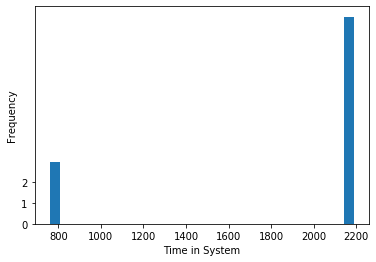

In [37]:
# Tinker with number of bins, until it looks right
plt.hist(system_times,bins=30)
# you can customize the exact tick marks on an axis
plt.yticks(range(0,3))
plt.ylabel('Frequency');
plt.xlabel('Time in System');

# Homework/In-class work

1. Suppose customers arrive to your queue with an exponentially distrubuted time between arrivals of 30 seconds and are served by one of two *parallel* servers, each server can, on average serve a customer in 50 seconds, with the service time exponentially distributed.

1. Now, return back to one server, but add a second server in *series*.  That is, each job first is serviced by a single Server 1, and then by a single Server 2.  Assume to exponential arrivals with a mean time between arrivals of 200 and exponential service time with mean of 190 for each server.  
   - Compute the average system time
   - Plot a histogram of total time in system


1. Of course, we may want to use other distributions in a simulation.  Write functions for the exponential and these other distributions,  `normal`, `triangular`,  and `uniform`, explore the `numpy` documentation:  https://docs.scipy.org/doc/numpy-1.14.0/reference/routines.random.html

   - remember, make sure your functions return only positive values for our purposes.
   - try out each of your functions to make sure they work as expected
   

1.  Consider the Paramount restaurant.  
    - Model a busy input stream of customers in the morning rush ...
    - Consider 4 cooks that ...
    - Consider community seating with XX seats and the dining experience ...
    